In [10]:
import sys
# sys.path.append("/home/diego/python/spike-train/") 
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")
sys.path.append("/home/diego/python/utils/") 
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import pickle

from gglm.utils import shift_array
from sptr.sptr import SpikeTrain
# from gglm.glm.base import GLM
from gglm.lif import LIF
from kernel.fun import KernelFun
from kernel.rect import KernelRect
from processes.ou import OUProcess
from processes.multivariate_ou import MultivariateOUProcess
# from icglm.kernels.rect import KernelRect

%load_ext autoreload
%autoreload 2
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def add_spikes(mask_spikes, dt, n=1, p=1, delay=4):
    mask_new_spikes = mask_spikes.copy()
    mask_selected = mask_spikes.copy()
    mask_selected[np.random.rand(*mask_selected.shape) > p] = False
    arg_delay = int(delay / dt)
    for ii in range(1, n + 1):
        _mask = shift_array(mask_selected, ii * arg_delay)
        mask_new_spikes = mask_new_spikes | _mask
    mask_spikes = mask_spikes | mask_new_spikes
    return mask_spikes

### diverging firing rate with poorly parametrized kernel

37.7
Starting gradient ascent... 

 Iteration 29 of 200 | Elapsed time: 0.2 seconds | objective=-15781.66
 
 Iteration 29 of 200 | Converged | Elapsed time: 0.0033 minutes | Log posterior is monotonic 

349.36


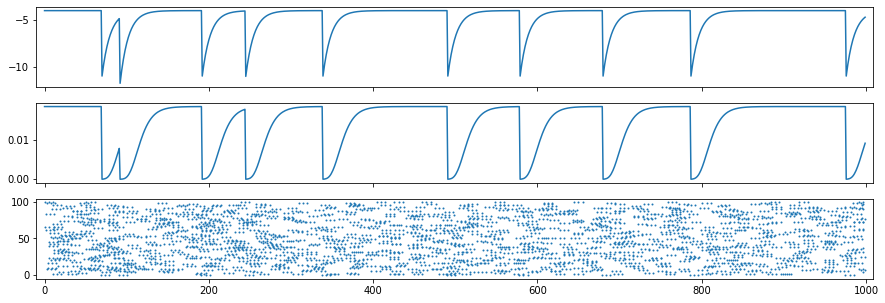

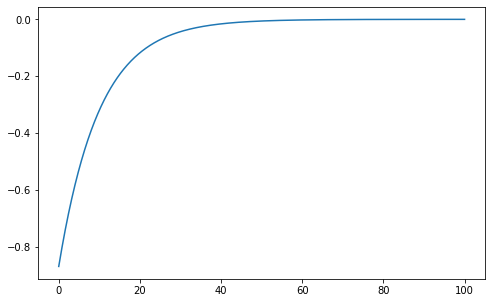

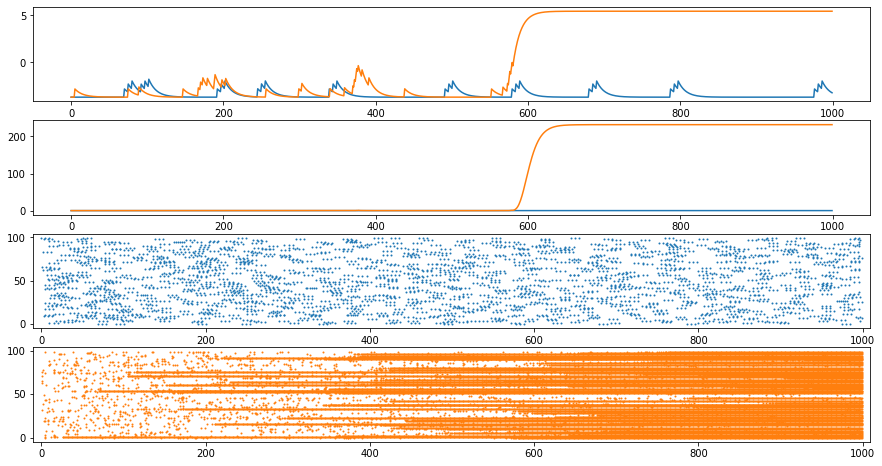

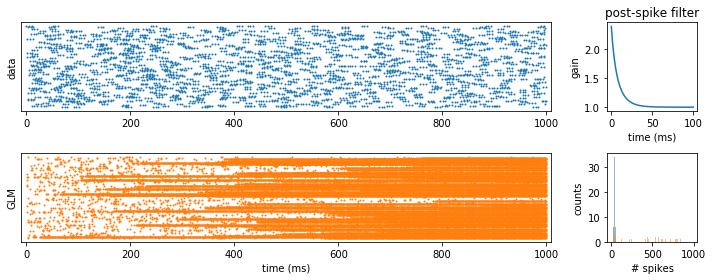

In [4]:
np.random.seed(0)

eta_tau = np.array([10])
ker = KernelFun.exponential(eta_tau, coefs=[7])

dt = 1
t = np.arange(0, 1000, dt)
glm = GLM(u0=4, eta=ker)

_u, _r, mask_spikes = glm.sample(t, shape=(100,))
mask_spikes = add_spikes(mask_spikes, dt, n=2, p=1, delay=5)
st_te = SpikeTrain(t, mask_spikes)

print(np.mean(np.sum(mask_spikes, 0)))

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), nrows=3, sharex=True)
ax1.plot(t, _u[:, 0])
ax2.plot(t, _r[:, 0])
st_te.plot(ax=ax3, ms=1)

glm_fit = GLM(u0=4, eta=KernelFun.exponential(eta_tau, coefs=[-2]))

glm_fit.fit(t, mask_spikes, verbose=True)

glm_fit.eta.plot()

mask_spikes_te = mask_spikes.copy()
u_fr, r_fr, mask_spikes_fr = glm_fit.sample(t, shape=(100,))
u_te, r_te = glm_fit.simulate_subthreshold(t, np.zeros(mask_spikes.shape), mask_spikes)
st_fr = SpikeTrain(t, mask_spikes_fr)

print(np.mean(np.sum(mask_spikes_fr, 0)))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(15, 8), nrows=4)
ax1.plot(t, u_te[:, 0])
ax1.plot(t, u_fr[:, 0])
ax2.plot(t, r_te[:, 0])
ax2.plot(t, r_fr[:, 0])
st_te.plot(ax=ax3, ms=1)
st_fr.plot(ax=ax4, ms=1, color='C1')

# fr_dist_te = np.sum(mask_spikes, 0) / 10
# fr_dist_fr = np.sum(mask_spikes_fr, 0) / 10
fr_dist_te = np.sum(mask_spikes, 0)
fr_dist_fr = np.sum(mask_spikes_fr, 0)

r1, r2 = 8, 2
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((2, r1 + r2), (0, 0), colspan=r1)
ax2 = plt.subplot2grid((2, r1 + r2), (1, 0), colspan=r1, sharex=ax1)
ax3 = plt.subplot2grid((2, r1 + r2), (0, r1), colspan=r2)
ax4 = plt.subplot2grid((2, r1 + r2), (1, r1), colspan=r2)
ti = np.arange(0, 100, .1)
eta_vals = glm_fit.eta.interpolate(ti)
ax3.plot(ti, np.exp(-eta_vals))
ax3.set_title('post-spike filter')
# glm_fit.eta.plot(ax=ax3, exp_values=True)
st_te.plot(ax=ax1, ms=1)
st_fr.plot(ax=ax2, ms=1, color='C1')
ax1.set_yticks([])
ax2.set_yticks([])
ax2.set_xlabel('time (ms)')
ax1.set_ylabel('data')
ax2.set_ylabel('GLM')

ax3.set_ylabel('gain')
ax3.set_xlabel('time (ms)')
bins = np.arange(0, 1000, 5)
ax4.hist(fr_dist_te, alpha=0.5, density=False, bins=bins)
ax4.hist(fr_dist_fr, alpha=0.5, density=False, bins=bins)
ax4.set_xlabel('# spikes')
# ax4.set_ylabel('p(# spikes)'); ax4.set_ylim(0, 0.04)
ax4.set_ylabel('counts')
fig.tight_layout()
fig.savefig('/home/diego/Dropbox/generative_glm/figures/diverging_firing_rate.pdf', bbox_inches='tight', transparent=True)

np.savez('diverging_fr', glm_u0=glm_fit.u0, glm_eta_tau=eta_tau, glm_eta_coefs=glm_fit.eta.coefs, t=t,
         mask_spikes_te=mask_spikes_te, mask_spikes_fr=mask_spikes_fr, u_te=u_te, u_fr=u_fr, r_te=r_te, r_fr=r_fr)

### bad ISI

In [32]:
np.random.seed(0)

ker = KernelFun.exponential([10], coefs=[7])

dt = 1
t = np.arange(0, 1000, dt)
glm = GLM(u0=4, eta=ker)

u, r, mask_spikes = glm.sample(t, shape=(100,))
mask_spikes = add_spikes(mask_spikes, dt, n=4, p=0.2, delay=5)
st_te = SpikeTrain(t, mask_spikes)

print(np.mean(np.sum(mask_spikes, 0)))

glm_fit = GLM(u0=4, eta=KernelFun.exponential([2, 20], coefs=[-2, 2]))

glm_fit.fit(t, mask_spikes, verbose=True)

u_fr, r_fr, mask_spikes_fr = glm_fit.sample(t, shape=(100,))
u_te, r_te = glm_fit.simulate_subthreshold(t, np.zeros(mask_spikes.shape), mask_spikes)
st_fr = SpikeTrain(t, mask_spikes_fr)

print(np.mean(np.sum(mask_spikes_fr, 0)))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(15, 8), nrows=4)
ax1.plot(t, u_te[:, 0])
ax1.plot(t, u_fr[:, 0])
ax2.plot(t, r_te[:, 0])
ax2.plot(t, r_fr[:, 0])
st_te.plot(ax=ax3, ms=1)
st_fr.plot(ax=ax4, ms=1, color='C1')

isi_te = st_te.isi_distribution()
isi_fr = st_fr.isi_distribution()

r1, r2 = 8, 2
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((2, r1 + r2), (0, 0), colspan=r1)
ax2 = plt.subplot2grid((2, r1 + r2), (1, 0), colspan=r1, sharex=ax1)
ax3 = plt.subplot2grid((2, r1 + r2), (0, r1), colspan=r2)
ax4 = plt.subplot2grid((2, r1 + r2), (1, r1), colspan=r2)
ti = np.arange(0, 100, .1)
eta_vals = glm_fit.eta.interpolate(ti)
ax3.plot(ti, np.exp(-eta_vals))
ax3.set_title('post-spike filter')
# glm_fit.eta.plot(ax=ax3, exp_values=True)
st_te.plot(ax=ax1, ms=1)
st_fr.plot(ax=ax2, ms=1, color='C1')
ax1.set_yticks([])
ax2.set_yticks([])
ax2.set_xlabel('time (ms)')
ax1.set_ylabel('data')
ax2.set_ylabel('GLM')

ax3.set_ylabel('gain')
ax3.set_xlabel('time (ms)')
bins = np.arange(0, 150, 5)
ax4.hist(isi_te, alpha=0.5, density=True, bins=bins)
ax4.hist(isi_fr, alpha=0.5, density=True, bins=bins)
ax4.set_xlabel('# spikes')
# ax4.set_ylabel('p(# spikes)'); ax4.set_ylim(0, 0.04)
ax4.set_ylabel('counts')
fig.tight_layout()
fig.savefig('/home/diego/Dropbox/generative_glm/figures/bad_isi.pdf', bbox_inches='tight', transparent=True)

TypeError: __init__() missing 1 required positional argument: 'kappa'

### fixed frequency fail

In [26]:
def add_jitter(t, mask_spikes, tau=0):
    mask_spikes_jitter = np.zeros(mask_spikes.shape, dtype=bool)
    arg_spikes = np.where(mask_spikes)
    t_spikes = t[arg_spikes[0]] + tau * np.random.randn(len(arg_spikes[0]))
    _arg_spikes = np.searchsorted(t, t_spikes)
    _arg_spikes[_arg_spikes < 0] = 0
    _arg_spikes[_arg_spikes > (len(t) - 1)] = (len(t) - 1)
    arg_spikes = (_arg_spikes,) + arg_spikes[1:]
    mask_spikes_jitter[arg_spikes] = True
    return mask_spikes_jitter
#     t_spikes[t_spikes >= t[-1]] = t[-1]
#     arg_spikes = 

Starting gradient ascent... 

 Iteration 47 of 200 | Elapsed time: 0.17 seconds | objective=-6533.94
 
 Iteration 47 of 200 | Converged | Elapsed time: 0.0028 minutes | Log posterior is monotonic 

20.0 22.69 20.03


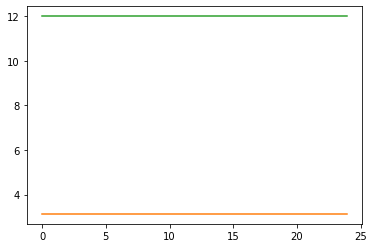

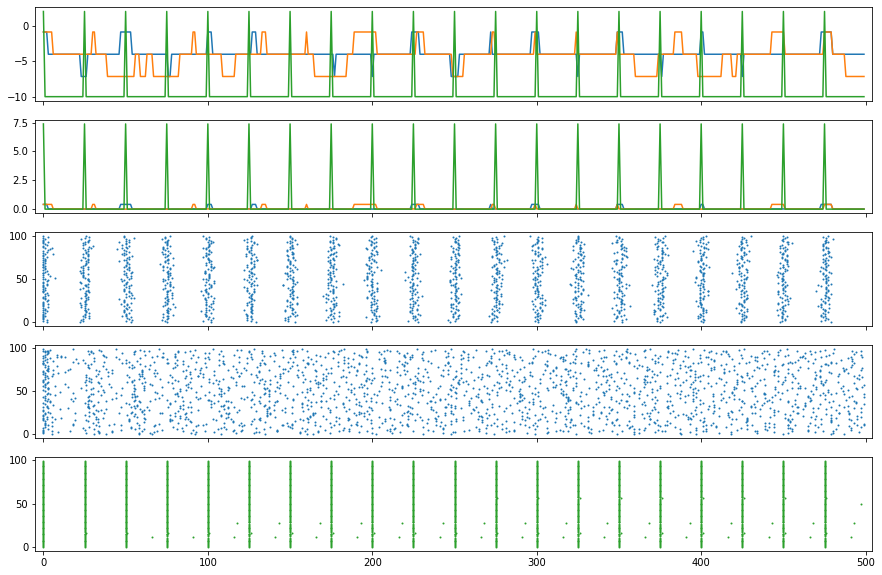

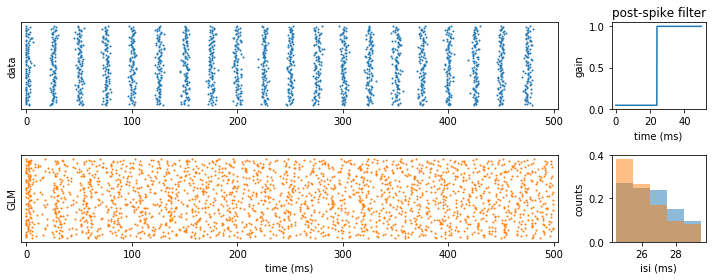

In [29]:
dt = 1
t = np.arange(0, 500, dt)

t_spk = np.arange(0, 1000, 25)
arg_spk = np.searchsorted(t, t_spk)
arg_spk = arg_spk[arg_spk < len(t)]
mask_spikes = np.zeros((len(t), 100), dtype=bool)
mask_spikes[arg_spk, :] = True
mask_spikes = add_jitter(t, mask_spikes, tau=2)

mask_spikes_te = mask_spikes.copy()
st_te = SpikeTrain(t, mask_spikes)

tf_eta = 24
tbins = [0, tf_eta]
glm_fit = GLM(u0=-2, eta=KernelRect(tbins, coefs=np.ones(len(tbins) - 1) * 8))

glm_fit.fit(t, mask_spikes, verbose=True)

coefs = np.zeros(len(tbins) - 1) + 12
glm_hc = GLM(u0=-2, eta=KernelRect(tbins, coefs=coefs))

ti = np.arange(0, tf_eta, .1)
fig, ax = plt.subplots()
glm_fit.eta.plot(t=ti, ax=ax, color='C1')
glm_hc.eta.plot(t=ti, ax=ax, color='C2')

u_fr, r_fr, mask_spikes_fr = glm_fit.sample(t, shape=(100,))
u_te, r_te = glm_fit.simulate_subthreshold(t, np.zeros(mask_spikes.shape), mask_spikes)
st_fr = SpikeTrain(t, mask_spikes_fr)

u_fr_hc, r_fr_hc, mask_spikes_fr_hc = glm_hc.sample(t, shape=(100,))
u_te_hc, r_te_hc = glm_hc.simulate_subthreshold(t, np.zeros(mask_spikes.shape), mask_spikes)
st_fr_hc = SpikeTrain(t, mask_spikes_fr_hc)

print(np.mean(np.sum(mask_spikes, 0)), np.mean(np.sum(mask_spikes_fr, 0)), np.mean(np.sum(mask_spikes_fr_hc, 0)))

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(15, 10), nrows=5, sharex=True)
ax1.plot(t, u_te[:, 0])
ax1.plot(t, u_fr[:, 0])
ax1.plot(t, u_fr_hc[:, 0])
ax2.plot(t, r_te[:, 0])
ax2.plot(t, r_fr[:, 0])
ax2.plot(t, r_fr_hc[:, 0])
st_te.plot(ax=ax3, ms=1)
st_fr.plot(ax=ax4, ms=1)
st_fr_hc.plot(ax=ax5, ms=1, color='C2')

bins = np.arange(-.5, 50, 2)
isi_te = st_te.isi_distribution()
isi_fr = st_fr.isi_distribution()

r1, r2 = 8, 2
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((2, r1 + r2), (0, 0), colspan=r1)
ax2 = plt.subplot2grid((2, r1 + r2), (1, 0), colspan=r1, sharex=ax1)
ax3 = plt.subplot2grid((2, r1 + r2), (0, r1), colspan=r2)
ax4 = plt.subplot2grid((2, r1 + r2), (1, r1), colspan=r2)
ti = np.arange(0, 50, .1)
eta_vals = glm_fit.eta.interpolate(ti)
ax3.plot(ti, np.exp(-eta_vals))
ax3.set_title('post-spike filter')
# glm_fit.eta.plot(ax=ax3, exp_values=True)
st_te.plot(ax=ax1, ms=1)
st_fr.plot(ax=ax2, ms=1, color='C1')
ax1.set_yticks([])
ax2.set_yticks([])
ax2.set_xlabel('time (ms)')
ax1.set_ylabel('data')
ax2.set_ylabel('GLM')

ax3.set_ylabel('gain')
ax3.set_xlabel('time (ms)')
bins = np.arange(24.5, 30.5, 1)
ax4.hist(isi_te, alpha=0.5, density=True, bins=bins)
ax4.hist(isi_fr, alpha=0.5, density=True, bins=bins)
ax4.set_xlabel('isi (ms)')
# ax4.set_ylabel('p(# spikes)'); ax4.set_ylim(0, 0.04)
ax4.set_ylabel('counts')
fig.tight_layout()
fig.savefig('/home/diego/Dropbox/generative_glm/figures/fixed_freq_fail.pdf', bbox_inches='tight', transparent=True)

np.savez('fixed_freq', glm_u0=glm_fit.u0, tf_eta=tf_eta, glm_eta_coefs=glm_fit.eta.coefs, t=t,
         mask_spikes_te=mask_spikes_te, mask_spikes_fr=mask_spikes_fr, u_te=u_te, u_fr=u_fr, r_te=r_te, r_fr=r_fr)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.192e+03, 5.990e+02, 1.020e+02, 6.000e+00]),
 array([ 8. , 10.5, 13. , 15.5, 18. , 20.5, 23. , 25.5, 28. , 30.5, 33. ]),
 <a list of 10 Patch objects>)

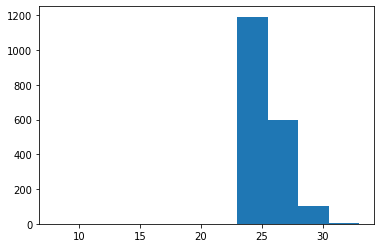

In [121]:
plt.hist(isi_fr)

### reliability fail with lif

72.52
Starting gradient ascent... 

 Iteration 50 of 200 | Elapsed time: 2.14 seconds | log_prior=nan | log_posterior=-5916.71
 
 Iteration 50 of 200 | Converged | Elapsed time: 0.0356 minutes | Log posterior is monotonic 

74.84
0.5309799595513881 0.2980580794584002


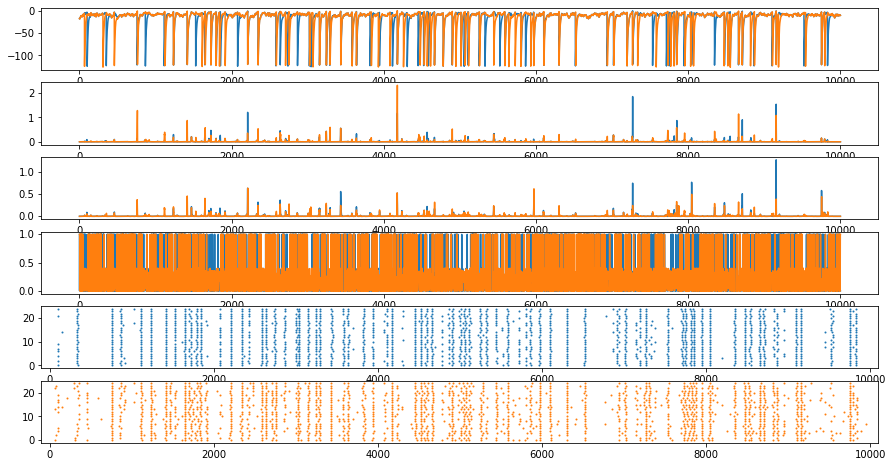

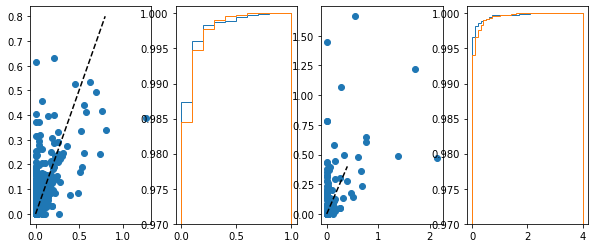

In [74]:
from icglm.models.glm import GLM

np.random.seed(0)

ker = KernelFun.exponential([10], coefs=[7])

dt = 1
t = np.arange(0, 10000, 1)
lif = LIF(tau=50, R=1e0, vr=-65, vt=-54, vrst=-60, tref=7)

r = 1
n = 25
cov = np.ones((n, n)) * r
cov[np.diag_indices(n)] = 1
# stim = MultivariateOUProcess(mu=10, cov=cov, tau=3).sample(t, shape=(n,))
stim = OUProcess(mu=10, sd=10, tau=3).sample(t, shape=(1,))
stim = np.stack([stim[:, 0]] * n, 1)

v, mask_spikes = lif.sample(-65, t, stim, sigma=0.5)

st_te = SpikeTrain(t, mask_spikes)

print(np.mean(np.sum(mask_spikes, 0)))

tbins = np.arange(0, 250, 10)
glm_fit = GLM(u0=4, kappa=KernelRect(tbins, coefs=1e-3 * np.exp(-tbins[:-1] / 50)), 
              eta=KernelFun.exponential([10], coefs=[7]))

glm_fit.fit(t, stim, mask_spikes, verbose=True)

u_fr, r_fr, mask_spikes_fr = glm_fit.sample(t, stim)
u_te, r_te = glm_fit.simulate_subthreshold(t, stim, mask_spikes)
st_fr = SpikeTrain(t, mask_spikes_fr)

print(np.mean(np.sum(mask_spikes_fr, 0)))
r_mean_te = np.mean(r_te, 1)
r_mean_fr = np.mean(r_fr, 1)
r2_mean_te = np.mean(r_te**2, 1)
r2_mean_fr = np.mean(r_fr**2, 1)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(15, 8), nrows=6)
ax1.plot(t, u_te[:, 0])
ax1.plot(t, u_fr[:, 0])
ax2.plot(t, r_te[:, 0])
ax2.plot(t, r_fr[:, 0])
ax3.plot(t, r_mean_te)
ax3.plot(t, r_mean_fr)
ker_gauss = KernelFun.gaussian_delta(1)
mean_spk_te = st_te.convolve(ker_gauss)
mean_spk_fr = st_fr.convolve(ker_gauss)
var_spk_te = np.var(mean_spk_te, 1)
var_spk_fr = np.var(mean_spk_fr, 1)
mean_spk_te = np.mean(mean_spk_te, 1)
mean_spk_fr = np.mean(mean_spk_fr, 1)
fano_te = st_te.sliding_fano_factor(ker_gauss)
fano_fr = st_fr.sliding_fano_factor(ker_gauss)
ax4.plot(t, fano_te)
ax4.plot(t, fano_fr)
st_te.plot(ax=ax5, ms=1)
st_fr.plot(ax=ax6, ms=1, color='C1')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(10, 4), ncols=4)
ax1.plot(r_mean_te, r_mean_fr, 'o')
ax1.plot([0, 0.8], [0, 0.8], 'k--')
bins = np.arange(0, 1.1, .1)
ax2.hist(r_mean_te, density=True, cumulative=True, histtype='step', bins=bins)
ax2.hist(r_mean_fr, density=True, cumulative=True, histtype='step', bins=bins)
ax2.set_ylim(0.97, 1.001)
ax3.plot(r2_mean_te, r2_mean_fr, 'o')
ax3.plot([0, 0.4], [0, 0.4], 'k--')
bins = np.arange(0, 4.1, .1)
ax4.hist(r2_mean_te, density=True, cumulative=True, histtype='step', bins=bins)
ax4.hist(r2_mean_fr, density=True, cumulative=True, histtype='step', bins=bins)
ax4.set_ylim(0.97, 1.001)

# fr_dist_te = np.sum(mask_spikes, 0) / 10
# fr_dist_fr = np.sum(mask_spikes_fr, 0) / 10
fr_dist_te = np.sum(mask_spikes, 0)
fr_dist_fr = np.sum(mask_spikes_fr, 0)

ker1, ker2 = KernelRect.kistler_kernels(2, 1)
print(st_te.reliability(ker1, ker2), st_fr.reliability(ker1, ker2))

# r1, r2 = 8, 2
# fig = plt.figure(figsize=(10, 4))
# ax1 = plt.subplot2grid((2, r1 + r2), (0, 0), colspan=r1)
# ax2 = plt.subplot2grid((2, r1 + r2), (1, 0), colspan=r1, sharex=ax1)
# ax3 = plt.subplot2grid((2, r1 + r2), (0, r1), colspan=r2)
# ax4 = plt.subplot2grid((2, r1 + r2), (1, r1), colspan=r2)
# ti = np.arange(0, 100, .1)
# eta_vals = glm_fit.eta.interpolate(ti)
# ax3.plot(ti, np.exp(-eta_vals))
# ax3.set_title('post-spike filter')
# # glm_fit.eta.plot(ax=ax3, exp_values=True)
# st_te.plot(ax=ax1, ms=1)
# st_fr.plot(ax=ax2, ms=1, color='C1')
# ax1.set_yticks([])
# ax2.set_yticks([])
# ax2.set_xlabel('time (ms)')
# ax1.set_ylabel('data')
# ax2.set_ylabel('GLM')

# ax3.set_ylabel('gain')
# ax3.set_xlabel('time (ms)')
# bins = np.arange(0, 1000, 5)
# ax4.hist(fr_dist_te, alpha=0.5, density=False, bins=bins)
# ax4.hist(fr_dist_fr, alpha=0.5, density=False, bins=bins)
# ax4.set_xlabel('# spikes')
# # ax4.set_ylabel('p(# spikes)'); ax4.set_ylim(0, 0.04)
# ax4.set_ylabel('counts')
# fig.tight_layout()
# # fig.savefig('/home/diego/Dropbox/generative_glm/figures/r.pdf', bbox_inches='tight', transparent=True)

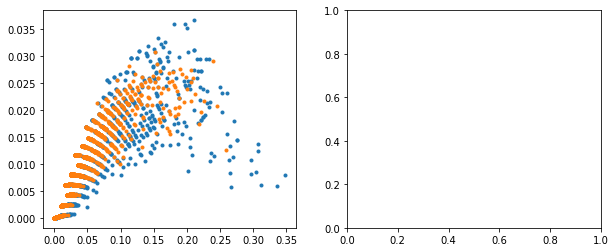

In [75]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)
ax1.plot(mean_spk_te, var_spk_te, '.')
ax1.plot(mean_spk_fr, var_spk_fr, '.')
# ax1.set_xlim(0, 0.25)
# ax1.set_ylim(0, 0.25)

In [ ]:
np.mean(r_te, 1)

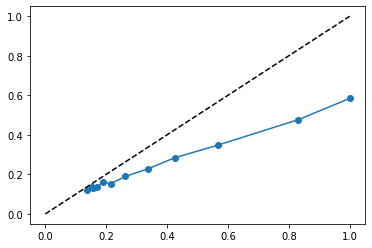

In [27]:
rel_te, rel_fr = [], []

for sigma in np.arange(0, 3, .25):
    v, mask_spikes = lif.sample(-65, t, stim, sigma=sigma)

    st_te = SpikeTrain(t, mask_spikes)

    tbins = np.arange(0, 250, 10)
    glm_fit = GLM(u0=4, kappa=KernelRect(tbins, coefs=1e-3 * np.exp(-tbins[:-1] / 50)), 
                  eta=KernelRect(tbins, coefs=1e-3 * np.exp(-tbins[:-1] / 50)))

    glm_fit.fit(t, stim, mask_spikes, verbose=False)

    u_fr, r_fr, mask_spikes_fr = glm_fit.sample(t, stim)
#     u_te, r_te = glm_fit.simulate_subthreshold(t, np.zeros(mask_spikes.shape), mask_spikes)
    st_fr = SpikeTrain(t, mask_spikes_fr)
    
    rel_te.append(st_te.reliability(ker1, ker2))
    rel_fr.append(st_fr.reliability(ker1, ker2))

fig, ax = plt.subplots()
ax.plot(rel_te, rel_fr, '-o')
ax.plot([0, 1], [0, 1], 'k--')